In [1]:
import string 
import glob 
from keras.preprocessing import image
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from time import time
import numpy as np 
import pickle 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Embedding, LSTM, Input
from keras.layers.merge import add

def load_doc(filename):
    with open(filename, 'r') as f:
        doc = f.read()
        f.close()
    return doc

Using TensorFlow backend.


In [2]:
filename = '/kaggle/input/image-captioning/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)

def get_descriptions(doc):
    descriptions = {}
    for line in doc.split('\n'):
        # split line by white space 
        token = line.split() 
    #     print(len(img_desc))
        if len(token) == 0:
            break
        # (format : 'img_idx.jpg#i description')
        img_idx, img_desc = token[0], token[1:]

        img_idx = img_idx.split('.')[0]
        img_desc = ' '.join(img_desc)
        if img_idx not in descriptions:
            descriptions[img_idx] = list()
        descriptions[img_idx].append(img_desc)
    return descriptions

token_descriptions = get_descriptions(doc)
print(token_descriptions['101654506_8eb26cfb60'])

['A brown and white dog is running through the snow .', 'A dog is running in the snow', 'A dog running through snow .', 'a white and brown dog is running through a snow covered field .', 'The white and brown dog is running over the surface of the snow .']


In [3]:
# DATA CLEANING
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)

    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            # convert to lower case 
            desc = [w.lower() for w in desc]
            # remove punctuation from each token 
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [w for w in desc if len(w)>1]
            # remove tokens with numbers in them 
            desc = [w for w in desc if w.isalpha()]
            # store as string 
            desc_list[i] = ' '.join(desc)
    return descriptions

token_descriptions = clean_descriptions(token_descriptions)
print(token_descriptions['101654506_8eb26cfb60'])
                   
        

['brown and white dog is running through the snow', 'dog is running in the snow', 'dog running through snow', 'white and brown dog is running through snow covered field', 'the white and brown dog is running over the surface of the snow']


In [4]:
def save_descriptions(descriptions, filename):
    lines = list()
    descriptions = clean_descriptions(descriptions)
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    with open(filename, 'w') as f:
        f.write(data)
        f.close()

save_descriptions(token_descriptions, 'descriptions.txt')

In [5]:
# Get id image corresponding : train, test, dev
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) == 0:
            break
        img_idx = line.split()[0]
#         print(line)
        dataset.append(img_idx)
    return set(dataset)

In [6]:
image_folder = '/kaggle/input/image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/' 
# Get all images in folder 
img = glob.glob(image_folder + '*.jpg')
print(img[0])

/kaggle/input/image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/3317145805_071b15debb.jpg


In [7]:
train_images_file = '/kaggle/input/image-captioning/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = load_set(train_images_file)
print("Training data size %d." %len(train_images))
# Create a list save full path train image
train_img = []

for i in img: 
    if i[len(image_folder):] in train_images:
        train_img.append(i)
print(train_img[0])

Training data size 6000.
/kaggle/input/image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/3317145805_071b15debb.jpg


In [8]:
test_images_file = '/kaggle/input/image-captioning/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = load_set(test_images_file)
print("Test data size %d." %len(test_images))
# create a list save full path test image
test_img = []

for i in img:
    if i[len(image_folder):] in test_images:
        test_img.append(i)
print(test_img[0])

Test data size 1000.
/kaggle/input/image-captioning/Flickr8k_Dataset/Flicker8k_Dataset/1394368714_3bc7c19969.jpg


In [9]:
# Add startseq and endseq 
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = {}
    for desc in doc.split('\n'):
        tokens = desc.split()
        if len(tokens) == 0:
            break
        img_idx, img_desc = tokens[0], tokens[1:]
        img_idx = img_idx + '.jpg'
        if img_idx in dataset:
            if img_idx not in descriptions:
                descriptions[img_idx] = list()
            img_desc = 'startseq ' + ' '.join(img_desc) +  ' endseq'
            descriptions[img_idx].append(img_desc)
    return descriptions


train_descriptions = load_clean_descriptions('descriptions.txt', train_images)
print("Train descriptions size : %d" %(len(train_descriptions)))

for key, line in train_descriptions.items():
    print(key, line)
    break

Train descriptions size : 6000
1000268201_693b08cb0e.jpg ['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [10]:
def preprocess_image(image_path):
    # Convert all images to size (299, 299) as expected by the inception_v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to np array of 3 dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # Preprocess the image using preprocess_input from inception module
    x = preprocess_input(x)
    return x 


In [11]:
# get the InceptionV3 model trained on imagenet data 
model = InceptionV3(weights='imagenet')
# drop the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

96116736/96112376 [==============================] - 1s 0us/step


In [12]:
def encode(img):
    img = preprocess_image(img)
    fea_vec = model_new.predict(img)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [13]:
def encode_all_images(image_path):
    start = time()
    encoding = {}
    for img in image_path:
        encoding[img[len(image_folder):]] = encode(img)
    print('Time take in seconds = %f' %(time()-start))
    return encoding

In [14]:
def save_pickle(filename, data):
    with open(filename, 'wb') as encoded_pickle:
        pickle.dump(data, encoded_pickle)

In [15]:
# start = time()
# encoding_train = {}
# for img in train_img:
#     encoding_train[img[len(image_folder):]] = encode(img)
# print('Time take in seconds = %2f' %(time()-start))
encoding_train = encode_all_images(train_img)

Time take in seconds = 221.561473


In [16]:
# Save encoding train 
# with open('/kaggle/working/encoded_train_images.pkl', 'wb') as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)
train_filename = '/kaggle/working/encoded_train_images.pkl'
save_pickle(train_filename, encoding_train)

In [17]:
# start = time()
# encoding_test = {}
# for img in test_img:
#     encoding_test[img[len(image_folder):]] = encode(img)
# print('Time take in seconds = %2f' %(time()-start))
encoding_test = encode_all_images(test_img)

Time take in seconds = 35.756350


In [18]:
# with open('/kaggle/working/encoded_test_images.pkl', 'wb') as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)
test_filename = '/kaggle/working/encoded_test_images.pkl'
save_pickle(test_filename, encoding_test)

In [19]:
train_features = pickle.load(open('/kaggle/working/encoded_train_images.pkl', 'rb')) 
print("Photos: train=%d." %len(train_features))

Photos: train=6000.


In [20]:
vocabulary = set()
for key in train_descriptions:
    [vocabulary.update(d.split()) for d in train_descriptions[key]]
print("Original vocabulary size: %d" %len(vocabulary))

Original vocabulary size: 7578


In [21]:
# Create a list of all the training caption 
all_training_caption = []
for key, val in train_descriptions.items():
    for desc in val:
        all_training_caption.append(desc)

word_count_threshold = 10 
word_count = {}
nsents = 0

# Only get words appear more than 10 times
for sent in all_training_caption:
    nsents += 1 
    for w in sent.split():
        word_count[w] = word_count.get(w, 0) + 1

vocab = [w for w in word_count if word_count[w]>=word_count_threshold]
print('Preprocessed word : %d ' %len(vocab))


Preprocessed word : 1651 


In [22]:
# Make two dictionary 
int2char = {ii : ch for ii,ch in enumerate(vocab)}
char2int = {ch : ii for ii,ch in enumerate(vocab)}
vocab_size = len(int2char) + 1
vocab_size

1652

In [23]:
def maxlength(descriptions):
    max_desc = 0
    for key, lines in descriptions.items():
        for desc in lines:
            tokens = desc.split()
            max_desc = max(max_desc, len(tokens))
    return max_desc
max_length = maxlength(train_descriptions)
print("Description Length %d ."  %max_length)

Description Length 34 .


In [24]:
def data_generator(descriptions, photos, char2int, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0 
    # loop for ever over images
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence 
                seq = [char2int[w] for w in desc.split() if w in char2int]
                # split one sequence into multiple X,y pairs 
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, ou_seq = seq[:i], seq[i]
                    # pad input
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    ou_seq = to_categorical([ou_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(ou_seq)
            
            if n == num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

In [25]:
import os 
# Load GLOVE vector 
glove_dir = '/kaggle/input/word-embedding/'
embedding_idx = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_idx[word] = coefs
f.close()

In [26]:
print(len(embedding_idx))

400000


In [27]:
embedding_dim = 200
# Get 200-dim dense vector for each of 10000 words in out vocabulary 
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in char2int.items():
    embedding_vector = embedding_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    


In [28]:
# image features extract from pretraied model
inputs1 = Input(shape=(2048, ))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length, ))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [29]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainabel = False

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [32]:
model.optimizer.learning_rate = 0.0001
epochs = 10 
num_pics_per_batch = 6
steps = len(train_descriptions)//num_pics_per_batch
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, char2int, max_length, num_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 3.2501
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 3.2002
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 3.1557
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 3.1172
Epoch 1/1
1000/1000 [==============================] - 69s 69ms/step - loss: 3.0843
Epoch 1/1
1000/1000 [==============================] - 68s 68ms/step - loss: 3.0514
Epoch 1/1
1000/1000 [==============================] - 69s 69ms/step - loss: 3.0212
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.9923
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.9669
Epoch 1/1
1000/1000 [==============================] - 67s 67ms/step - loss: 2.9417


In [33]:
model.save_weights('/kaggle/working/model1.h5')

In [38]:
with open('/kaggle/working/encoded_test_images.pkl', 'rb') as f:
    encoded_test = pickle.load(f)

In [65]:
def GreedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        # convert to index 
        sequence = [char2int[w] for w in in_text.split() if w in char2int]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_hat = model.predict([photo, sequence], verbose=0)
        y_hat = np.argmax(y_hat)
        word = int2char[y_hat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    out = in_text.split()
    out = out[1:-1]
    out = ' '.join(out)
    return out 
        

Greedy : man and woman are standing on the beach


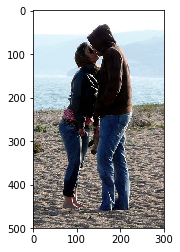

In [66]:
import matplotlib.pyplot as plt 
%matplotlib inline 

idx = 5
img_name = list(encoded_test.keys())[idx]
img_fea = encoded_test[img_name].reshape((1, 2048))
x = plt.imread(image_folder+img_name)
plt.imshow(x)

print("Greedy : " + GreedySearch(img_fea))